In [1]:
%matplotlib notebook

import brian2 as b2
import numpy
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from input_factory import get_step_current, get_ou_current
from plot_tools import plot_voltage_and_current_traces

In [2]:
model_eqs = '''
dv/dt = (-gL*(v-v_rest) - w1 - w2 + I_ext(t))/C : volt

dw1/dt = -w1/tau_w1 : amp
dw2/dt = -w2/tau_w2 : amp

dvt1/dt = -vt1/tau_vt1 : volt
dvt2/dt = -vt2/tau_vt2 : volt
 
vt = v_thresh + vt1 + vt2 : volt
lambda_t = lambda_0*exp((v-vt)/del_v): Hz
'''
reset_eqs = '''
v = v_reset
w1+=amp_w1
w2+=amp_w2
vt1+=amp_vt1
vt2+=amp_vt2
'''

In [3]:
nfs_df = pd.read_csv('data/nfs.txt',header = None)
nfs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']
fs_df = pd.read_csv('data/fs.txt',header = None)
fs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']

In [4]:
nfs_df

,C (nF),gL (usiemens),v_rest (mV),v_reset (mV),tau_refr (ms),v_thresh (mV),del_v (mV),amp_w1 (nA),tau_w1 (ms),amp_w2 (nA),tau_w2 (ms),amp_vt1 (mV),tau_vt1 (ms),amp_vt2 (mV),tau_vt2 (ms)
0,0.101900,0.004800,-62.600,-40.000,4,-50.000,0.10000,0.029000,20.580,0.000000,1.000,3.6400,21.880,1.24000,336.500
1,0.046083,0.006613,-71.197,-48.420,4,-48.085,0.63436,0.031839,11.459,0.001565,500.000,5.6645,11.548,0.63820,473.670
2,0.030942,0.005471,-63.021,-42.268,4,-39.358,0.78475,0.265740,80.066,-0.232230,85.274,4.7549,92.607,-2.36170,92.607
3,0.041975,0.002926,-61.654,-40.247,4,-49.110,1.29580,0.015207,13.165,0.016220,70.760,5.8349,31.895,1.93800,382.210
4,0.045642,0.006588,-71.209,-48.420,4,-48.277,0.64666,0.031817,11.284,0.001486,500.000,5.5064,12.821,0.61197,479.380
5,0.054226,0.005462,-59.786,-38.673,4,-44.469,1.23730,0.047379,19.093,-0.000802,282.060,4.8531,14.142,1.48370,347.690
6,0.038200,0.005937,-67.806,-45.313,4,-41.866,0.75960,0.051750,34.338,-0.012963,118.450,-4.0874,66.752,5.95560,66.752


In [5]:
print('R_in_nfs',1/nfs_df.iloc[0,:][1])
print('tau_nfs',nfs_df.iloc[0,:][0]/nfs_df.iloc[0,:][1])

R_in_nfs 208.333333333
tau_nfs 21.2291666667


In [6]:
b2.start_scope()
nfs_param = nfs_df.iloc[0,:] #set which value to try out, set any if running through all
C = nfs_param['C (nF)'] * b2.nF
gL = nfs_param['gL (usiemens)'] * b2.usiemens
v_rest = nfs_param['v_rest (mV)'] * b2.mV
v_reset = nfs_param['v_reset (mV)'] * b2.mV
tau_refr = nfs_param['tau_refr (ms)'] * b2.ms

v_thresh = nfs_param['v_thresh (mV)'] * b2.mV
del_v = nfs_param['del_v (mV)'] * b2.mV
amp_w1 = nfs_param['amp_w1 (nA)'] * b2.nA
tau_w1 = nfs_param['tau_w1 (ms)'] * b2.ms
amp_w2 = nfs_param['amp_w2 (nA)'] * b2.nA
tau_w2 = nfs_param['tau_w2 (ms)'] * b2.ms

amp_vt1 = nfs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1 = nfs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2 = nfs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2 = nfs_param['tau_vt2 (ms)'] * b2.ms

In [46]:
## amplitude to be played with 
# I_ext = get_step_current(t_start = 100, t_end = 700, unit_time = 1*b2.ms, amplitude = 0.08*b2.namp)
I_ext = get_ou_current(1,Delta_sigma=2.0,sigma_0=10.0)
rate_0 = b2.defaultclock.dt/b2.ms * b2.Hz
time = 1000 * b2.ms
lambda_0 = 10 * b2.kHz
VIP = b2.NeuronGroup(1, model = model_eqs, reset = reset_eqs, threshold = "v > vt",refractory = tau_refr, method = 'rk4')
VIP.v = v_rest
voltage_monitor_vip = b2.StateMonitor(VIP, ['v','vt','w1','w2'], record=True)
spike_monitor_vip = b2.SpikeMonitor(VIP)

vip_monitors = [voltage_monitor_vip, spike_monitor_vip]
print("Before simulation" , datetime.datetime.now())

vip_net = b2.Network(VIP)
vip_net.add(vip_monitors)
vip_net.run(time)

print("After simulation" , datetime.datetime.now())

Before simulation 2018-07-25 10:14:54.544824
After simulation 2018-07-25 10:14:57.404112


<IPython.core.display.Javascript object>


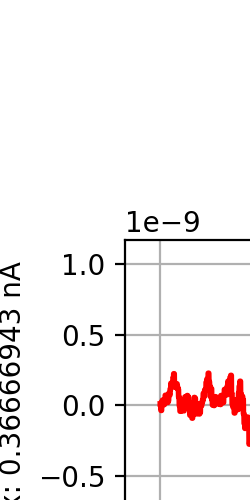

In [47]:
fig2 = plt.figure(figsize=(5,10))
plot_voltage_and_current_traces(voltage_monitor_vip, spike_monitor_vip, I_ext,title = 'NFS neuron')
plt.show()

In [48]:
fig2.savefig('../figs/25_nfsou.jpg')